In [1]:
using CSV
using Pandas

# Reading the dataset into a Pandas dataframe
df = DataFrame(CSV.read("Fish.csv"));

In [2]:
# Renaming the columns accordingly
proper_columns = Dict([
    "Length1" => "Vertical_length",
    "Length2"=> "Diagonal_length",
    "Length3"=> "Cross_length"
])

raw_fish_data = rename(df, columns=proper_columns)
sample(raw_fish_data, 5)

,Diagonal_length,Width,Vertical_length,Cross_length,Species,Weight,Height
85,21.3,3.5340,19.3,22.8,Perch,130.0,6.3840
107,28.7,4.6354,26.9,30.1,Perch,300.0,7.5852
100,25.6,4.2390,23.5,27.0,Perch,197.0,6.5610
1,26.3,4.3056,24.0,31.2,Bream,290.0,12.4800
77,18.0,3.3216,16.2,19.2,Perch,100.0,5.2224


In [3]:
using PyPlot

# Visualizing every feature's plot against the weight (target)
function scatter_fish(ox, oy, label_x, label_y)
    plot = PyPlot.scatter(ox, oy, marker="+", s=5)
    xlabel(label_x)
    ylabel(label_y)
    grid("on")
    
    return plot
end

function visualize_fish(data)
    fig = figure(figsize=(16,8))

    subplot(231)
    scatter_fish(data["Weight"], data["Diagonal_length"], "Weight (g)", "Diagonal Length (cm)")

    subplot(232)
    scatter_fish(data["Weight"], data["Vertical_length"], "Weight (g)", "Vertical Length (cm)")

    subplot(233)
    scatter_fish(data["Weight"], data["Cross_length"], "Weight (g)", "Crosss Length (cm)")

    subplot(234)
    scatter_fish(data["Weight"], data["Height"], "Weight (g)", "Height (cm)")

    subplot(235)
    scatter_fish(data["Weight"], data["Width"], "Weight (g)", "Width (cm)")
end

visualize_fish (generic function with 1 method)

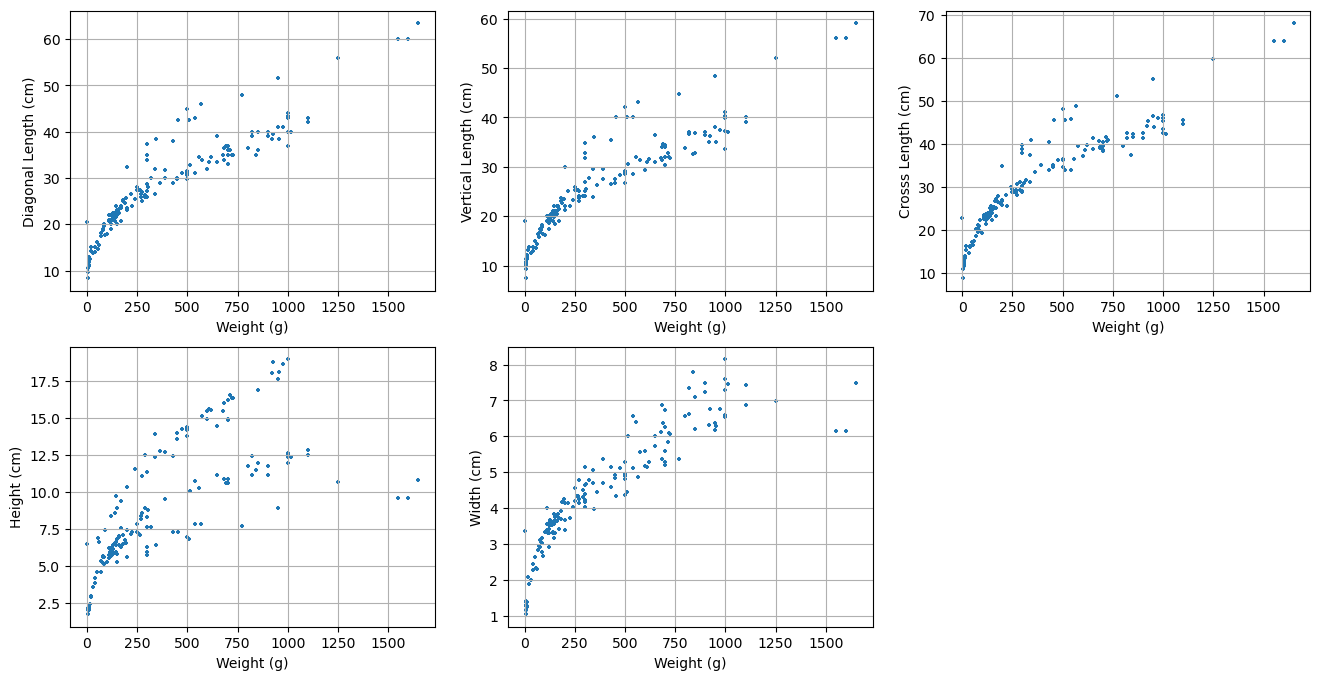

PyObject <matplotlib.collections.PathCollection object at 0x000000003D8C34F0>

In [4]:
visualize_fish(raw_fish_data)

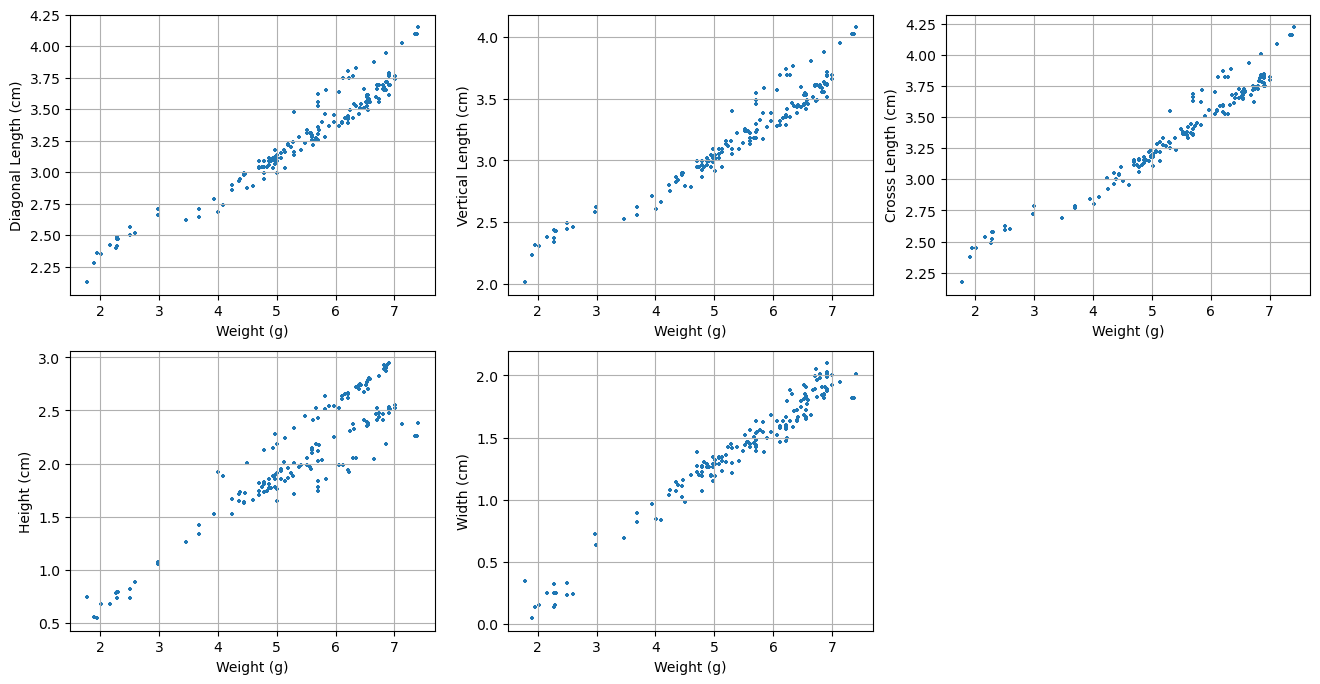

PyObject <matplotlib.collections.PathCollection object at 0x000000003A357400>

In [5]:
# Linearize the data
log_fish_data = Pandas.DataFrame(raw_fish_data)

cols_to_log = [
    0 => "Weight",
    1 => "Width",
    2 => "Height",
    3 => "Vertical_length",
    4 => "Cross_length",
    5 => "Diagonal_length"
]

for (key, value) in cols_to_log
    log_fish_data[value] = log.(log_fish_data[value])
end

log_fish_data = Pandas.replace(log_fish_data, [-Inf], NaN)
log_fish_data = Pandas.dropna(log_fish_data);

visualize_fish(log_fish_data)

In [6]:
# Number of rows
size(log_fish_data, 1)

158

In [7]:
# Shuffle the data
log_fish_data = sample(log_fish_data, frac=1)

# Split into test and train
fish_train = reset_index(head(log_fish_data, 108), drop=true)
fish_test = reset_index(tail(log_fish_data, 50), drop=true);

In [8]:
using GLM

# The three lengths are very similar => multicolinearity
# We use just one of them
linearRegressor = GLM.lm(@formula(Weight~Width+Height+Cross_length), fish_train)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Weight ~ 1 + Width + Height + Cross_length

Coefficients:
──────────────────────────────────────────────────────────────────────────
                 Coef.  Std. Error       t  Pr(>|t|)  Lower 95%  Upper 95%
──────────────────────────────────────────────────────────────────────────
(Intercept)   -1.99095   0.146536   -13.59    <1e-24  -2.28153   -1.70036
Width          1.13651   0.0681841   16.67    <1e-30   1.0013     1.27172
Height         0.41501   0.0377888   10.98    <1e-18   0.340073   0.489946
Cross_length   1.47454   0.0622025   23.71    <1e-43   1.35119    1.59789
──────────────────────────────────────────────────────────────────────────

In [9]:
# R square value

r2(linearRegressor)

0.9957960096822905

In [10]:
fish_test_predict = predict(linearRegressor, fish_test);

In [11]:
using Distances

actual_y = Array(fish_test["Weight"])
predicted_y = fish_test_predict

rmsd(actual_y, predicted_y)

0.12754489190412943

In [12]:
# Values range from 1.9 to 7.5. 0.1 rmsd should be fine
Pandas.describe(fish_test["Weight"])

count    50.000000
mean      5.534960
std       1.071789
min       1.774952
25%       4.976734
50%       5.637841
75%       6.338670
max       6.922644
Name: Weight, dtype: float64